# R regression tutorial
<i> Authors: Markus Viljanen </i>

In this tutorial we show how to estimate the expected number of purchases or expected purchase amount in censored data sets. Because our Python MCF packages does not (yet) support regression we use the 'survival' package in R to model the recurrent event process. Unfortunately, the 'survival' package does not seem to fully support the robust confidence intervals for predictions of $E[N(t)]$.

<p><b> Table of contents </b></p>
<ul>
  <li><a href='#imports'>Imports</a></li>
  <li><a href='#compare'>Compare purchases</a></li>
  <li><a href='#regression1'>Regression (purchase counts)</a></li>
  <li><a href='#regression2'>Regression (purchase amounts)</a></li>
  <li><a href='#extrapolation'>Extrapolation (purchase counts)</a></li>
  <li><a href='#conclusion'>Conclusion</a></li>
</ul>

<a id='imports'></a>

## Imports

In [1]:
library(survival)
library(forestplot)

Warning message:
"package 'survival' was built under R version 3.6.3"Warning message:
"package 'forestplot' was built under R version 3.6.3"Loading required package: grid
Loading required package: magrittr
Warning message:
"package 'magrittr' was built under R version 3.6.3"Loading required package: checkmate
Warning message:
"package 'checkmate' was built under R version 3.6.3"

<a id='compare'></a>

## Compare purchases

In this section we perform the same 'ios' vs. 'android' comparison, but use a regression model instead.

First we load the data set:

In [2]:
df <- read.table("tutorial/purchases_compare.csv", header=T, sep=',')
head(df)

Sample,Time,Time_prev,Event,Cost,Platform
1,120.79923,0,0,0,ios
2,175.80728,0,0,0,ios
3,135.02595,0,0,0,ios
4,166.04300,0,0,0,ios
5,25.20539,0,0,0,ios
6,19.20115,0,0,0,ios


The regression model is a Cox proportional hazards model. We fit it with robust confidence intervals by defining a cluster based on the sample identifier. The model then estimates a coefficient 'exp(coef)', which is the factor by which the platform 'ios' has a higher monetization than the baseline:

In [3]:
cox.robust <- coxph(Surv(Time_prev,Time,Event) ~ Platform + cluster(Sample), data=df)
cox.results <- summary(cox.robust)
cox.results$coefficients

,coef,exp(coef),se(coef),robust se,z,Pr(>|z|)
Platformios,0.5708377,1.769749,0.3944417,0.3860067,1.478829,0.1391861


In fact, we obtain a very similar p-value:

In [4]:
cox.results$robscore['pvalue']

pvalue 
0.1437

There can be small differences, because the regression model assumes that the hazards are proportional whereas the MCF comparison does not. 

<a id='regression1'></a>

## Regression (purchase counts)

In this section we fit a full regression model for the different cohorts. Every player is defined by categorical variables based on two platforms (android, ios), four countries (GB, US, AU, NL), and three difficulty levels (easy, normal, hard). We take the cohort android/GB/normal as baseline. 

First, load the data set:

In [5]:
df <- read.table("tutorial/purchases_regression.csv", header=T, sep=',')
df$Platform <- relevel(df$Platform, ref='android')
df$Country <- relevel(df$Country , ref='GB')
df$Difficulty <- relevel(df$Difficulty, ref='normal')
head(df)

Sample,Time,Time_prev,Event,Cost,Platform,Country,Difficulty
1,22.89228,0,0,0,android,GB,easy
2,16.52888,0,0,0,android,GB,easy
3,130.66217,0,0,0,android,GB,easy
4,108.49709,0,0,0,android,GB,easy
5,117.50500,0,0,0,android,GB,easy
6,83.84961,0,0,0,android,GB,easy


We then fit the Cox proportional hazards model with robust confidence intervals. Every 'exp(coef)' coefficient describes the effect of this platform, country, or difficulty variable in contrast to the baseline android/GB/normal:

In [6]:
cox.robust <- coxph(Surv(Time_prev,Time,Event) ~ Platform + Country + Difficulty + cluster(Sample), data=df)
cox.results <- summary(cox.robust)
cox.results$coefficients

,coef,exp(coef),se(coef),robust se,z,Pr(>|z|)
Platformios,0.3350040,1.3979460,0.1291242,0.1428455,2.3452184,1.901594e-02
CountryAU,0.8691903,2.3849791,0.1641834,0.1873784,4.6386906,3.506235e-06
CountryNL,-0.7031034,0.4950466,0.2394614,0.2515688,-2.7948757,5.191967e-03
CountryUS,-0.1364939,0.8724116,0.2027273,0.2253681,-0.6056487,5.447481e-01
Difficultyeasy,-0.3264905,0.7214512,0.1562992,0.1766487,-1.8482475,6.456654e-02
Difficultyhard,-0.2427894,0.7844367,0.1510550,0.1653612,-1.4682371,1.420398e-01


The results are reasonably close to the true values. Remember that we generated the data by assuming that the baseline rate is multiplied as follows:

```
Platform = ios | 1.5
Country = AU | 2.0
Country = NL | 0.5
Country = US | 1.0
Difficulty = easy | 0.95
Difficulty = hard | 0.95
```


The 'forestplot' package can be used to visualize the cofficients and their confidence intervals:

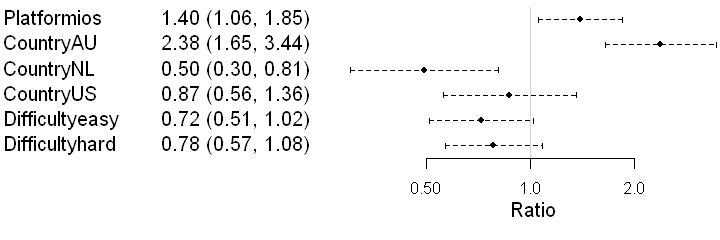

In [7]:
coef <- cox.results$coefficients[,'coef']
se <- cox.results$coefficients[,'robust se']
mean <- exp(coef)
ci.lower <- exp(coef - 1.96*se)
ci.upper <- exp(coef + 1.96*se)
options(repr.plot.width = 6, repr.plot.height = 2)
p3x <- forestplot(df.plot <- cbind(names(coef), sprintf("%.2f (%.2f, %.2f)", mean, ci.lower, ci.upper)),
                  mean=mean, lower=ci.lower, upper=ci.upper, xlog=T, xlab="Ratio",
                  boxsize=0.25, fn.ci_norm = fpDrawCircleCI, lty.ci=2, col=fpColors(box=c("black"), lines=c("black")),
                  txt_gp=fpTxtGp(label=gpar(cex=1.0), ticks=gpar(cex=0.8), xlab=gpar(cex=1.0))
)

Finally, we predict the expected number of sessions in each cohort and save them to the file 'purchases_regression_predict.csv'. This file is used to visualize the predictions in the Python MCF tutorial:

In [8]:
results = list()
t = sort(unique(df$Time))
for (platform in levels(df$Platform)) {
  for (country in levels(df$Country)) {
    for (difficulty in levels(df$Difficulty)) {
      cohort = paste(c(platform, country, difficulty), collapse=', ' )
      fr = data.frame(Time_prev=0, Time=t, Event=0, Platform=platform, Country=country, Difficulty=difficulty)
      reg = predict(cox.robust, newdata=fr, type='expected', se.fit=T)
      fr$N = reg$fit
      fr$N.var = reg$se.fit**2
      results[[cohort]] = fr[c('Time', 'N', 'N.var', 'Platform', 'Country', 'Difficulty')]
    }
  }
}
results = do.call("rbind", results)
write.table(results, 'tutorial/purchases_regression_predict.csv', row.names=F, sep=',')

<a id='regression2'></a>

## Regression (purchase amounts)

We fit the standard least squares regression model to the purchase amounts. We could fit one with robust confidence intervals by using the Generalized Estimating Equation (GEE) model, but this should not make a large difference because there is no correlation between i.i.d. purchases. Every 'exp(coef)' coefficient describes the effect of this platform, country, or difficulty variable in contrast to the baseline android/GB/normal:

In [9]:
#Robust regression
#lsq.robust <- gee(Cost ~ Platform + Country + Difficulty, id=Sample, data=df, subset=(df$Event == 1),
#                  family = gaussian, corstr = "independence")

#Standard regression
lsq <- lm(Cost ~ Platform + Country + Difficulty, data=df, subset=(df$Event == 1))
lsq.results <- summary(lsq)
lsq.results$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),2.09383411,0.4878614,4.29186234,2.567961e-05
Platformios,0.14843481,0.3467008,0.42813516,6.689351e-01
CountryAU,0.01744121,0.4355157,0.04004726,9.680886e-01
CountryNL,-0.16449206,0.6348783,-0.25909226,7.957852e-01
CountryUS,-0.37985888,0.5418329,-0.70106280,4.839402e-01
Difficultyeasy,-0.21171176,0.4155938,-0.50941987,6.109241e-01
Difficultyhard,-0.17128843,0.4027463,-0.42530109,6.709967e-01


Remember that we generated the data by assuming that the purchase amounts do not vary by cohort. We should therefore obtain an intercept of around 2.00 and coefficients of around 0.00. This is again quite close to the actual results.

The 'forestplot' package can again be used to visualize the cofficients and their confidence intervals:

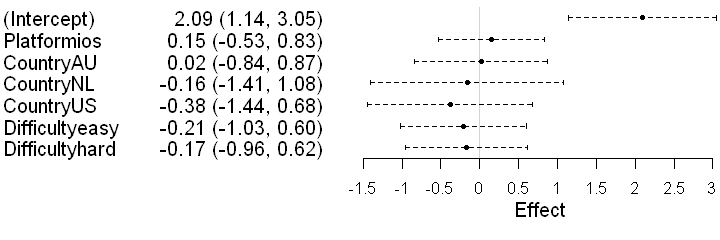

In [10]:
coef <- lsq.results$coefficients[,'Estimate']
se <- lsq.results$coefficients[,'Std. Error']
mean <- coef
ci.lower <- coef - 1.96*se
ci.upper <- coef + 1.96*se
p3x <- forestplot(df.plot <- cbind(names(coef), sprintf("%.2f (%.2f, %.2f)", mean, ci.lower, ci.upper)),
                  mean=mean, lower=ci.lower, upper=ci.upper, xlog=F, xlab="Effect",
                  boxsize=0.25, fn.ci_norm = fpDrawCircleCI, lty.ci=2, col=fpColors(box=c("black"), lines=c("black")),
                  txt_gp=fpTxtGp(label=gpar(cex=1.0), ticks=gpar(cex=0.8), xlab=gpar(cex=1.0))
)

Finally, we predict the expected purchase amounts in each cohort and save them to the file 'purchases_regression_amount.csv'. This file is used to visualize the predictions in the Python MCF tutorial:

In [11]:
results = list()
t = sort(unique(df$Time))
for (platform in levels(df$Platform)) {
  for (country in levels(df$Country)) {
    for (difficulty in levels(df$Difficulty)) {
      cohort = paste(c(platform, country, difficulty), collapse=', ' )
      fr = data.frame(Platform=platform, Country=country, Difficulty=difficulty)
      reg = predict(lsq, newdata=fr, se.fit=T)
      fr$E = reg$fit
      fr$E.var = reg$se.fit**2
      results[[cohort]] = fr[c('E', 'E.var', 'Platform', 'Country', 'Difficulty')]
    }
  }
}
results = do.call("rbind", results)
write.table(results, 'tutorial/purchases_regression_amount.csv', row.names=F, sep=',')

<a id='extrapolation'></a>

## Extrapolation (purchase counts)

In this section we fit the Cox proportional hazards regression model for the 'new' and 'old' game versions. The 'old' version is used as a baseline.

First, load the data set:

In [12]:
df <- read.table("tutorial/purchases_extrapolate.csv", header=T, sep=',')
df$Version <- relevel(df$Version , ref='old')

We then fit the Cox proportional hazards model with robust confidence intervals. The 'exp(coef)' coefficient describes the effect of the 'new' version in relation to the old. It is hypothesized that the 'new' version has an expected number of purchases curve which is proportional, i.e. the same as the 'old' $E[N(t)]$ curve multiplied exp(coef) coefficient. This fact is used to extrapolate the purchase amounts in the new version:

In [13]:
cox.robust <- coxph(Surv(Time_prev,Time,Event) ~Version + cluster(Sample), data=df)
cox.results <- summary(cox.robust)
cox.results$coefficients

,coef,exp(coef),se(coef),robust se,z,Pr(>|z|)
Versionnew,0.2598559,1.296743,0.3495266,0.3539431,0.7341743,0.4628425


Finally, we predict the expected number of sessions in each cohort and save them to the file 'purchases_extrapolate_predict.csv'. This file is used to visualize the predictions in the Python MCF tutorial:

In [14]:
results = list()
t = sort(unique(df$Time))
for (version in levels(df$Version)) {
  fr = data.frame(Time_prev=0, Time=t, Event=0, Version=version)
  reg = predict(cox.robust, newdata=fr, type='expected', se.fit=T)
  fr$N = reg$fit
  fr$N.var = reg$se.fit**2
  results[[version]] = fr[c('Time', 'N', 'N.var', 'Version')]
}
results = do.call("rbind", results)
write.table(results, 'tutorial/purchases_extrapolate_predict.csv', row.names=F, sep=',')

<a id='conclusion'></a>

## Conclusion

Thats all. Now open the Python MCF tutorial to see additional visualizations of the results.